In [53]:
import os, yaml
import numpy as np
import matplotlib.pyplot as plt

from phystem.systems.ring import utils
from phystem.core.run_config import load_cfg

In [54]:
def load(frame, offset,  data_dir):
    file1 = os.path.join(data_dir, f"pos_{frame}.npy")
    file2 = os.path.join(data_dir, f"pos_{frame+offset}.npy")
    pos1 = np.load(file1)
    pos2 = np.load(file2)
    return pos1, pos2

def calc_sd(p1, p2, space_cfg):
    cm1 = utils.get_cm(p1)
    cm2 = utils.get_cm(p2)

    # return np.square(cm1 - cm2).sum(axis=1)
    return np.square(utils.get_dist_pb(cm1, cm2, space_cfg.height, space_cfg.length)).sum(axis=1)

def calc_total_sq(offset, space_cfg, num_frames, data_dir):
    sq_data = []
    for frame in range(0, num_frames-offset, offset):
        p1, p2 = load(frame, offset, data_dir)
        square_d = calc_sd(p1, p2, space_cfg)

        sq_data.append(square_d)
    sq_data = np.array(sq_data)

    return sq_data

def get_msd_data(root_dir):
    data_dir = os.path.join(root_dir, "data")

    with open(os.path.join(root_dir, "metadata.yaml")) as f:
        num_frames = yaml.unsafe_load(f)["count"]
    cfgs = load_cfg("data/test/config.yaml")

    frame_dt = cfgs["run_cfg"].func_cfg["dt"]
    sq_mean = []
    time_step = []
    for offset in range(1, int(num_frames/2)):
        sq_data = calc_total_sq(offset, cfgs["space_cfg"], num_frames, data_dir)
        sq_mean.append(sq_data.mean())
        time_step.append(offset * frame_dt)

    sq_mean = np.array(sq_mean)
    time_step = np.array(time_step)

    return (time_step, sq_mean)

In [74]:
rot_diff = [0.1, 0.5, 1]
msd_data = [] 

for root_dir in ["rot_0_1", "rot_0_5", "rot_1"]:
    msd_data.append(get_msd_data(os.path.join("data", root_dir)))

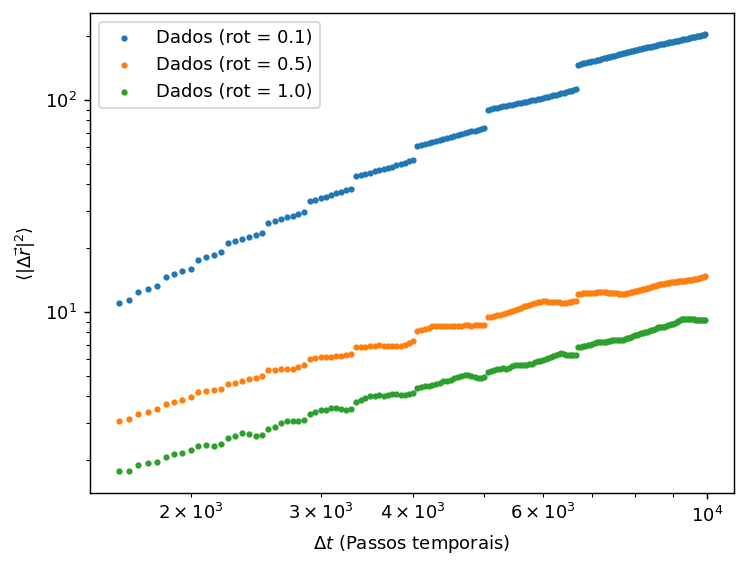

In [92]:
plt.figure(dpi=130)

plt.xlabel("$\Delta t$ (Passos temporais)")
plt.ylabel("$\\langle |\\Delta \\vec r|^2 \\rangle$")
plt.yscale("log")
plt.xscale("log")


rot_diff = np.array(rot_diff)
z_value = (rot_diff - rot_diff.min())/(rot_diff.max() - rot_diff.min())
z_value = [0.5 -0.3, 0.5, 0.5+0.3]
for idx, rd in enumerate(rot_diff):
    x_time = msd_data[idx][0] / 0.01
    sq_mean = msd_data[idx][1]

    mask = x_time > 10**3.2

    plt.scatter(x_time[mask], sq_mean[mask], label=f"Dados (rot = {rd})", s=6)


# x_time, sq_mean = msd_data[-1]
# x_time = x_time / 0.01
# half_mask = x_time > (x_time[-1]*x_time[0])**.5

# x_linear = x_time[half_mask]
# plt.plot(x_linear, 1/2 * sq_mean[-1]/x_linear[-1] * x_linear, label="y~x", c="red")

# x_square = x_time[np.logical_not(half_mask)]
# plt.plot(x_square, 1/4 * sq_mean[0] * (x_square/x_square[0])**2, label="y~x²", c="g")

plt.legend()
# plt.savefig("data/images/multiple_rots_zoom.png")

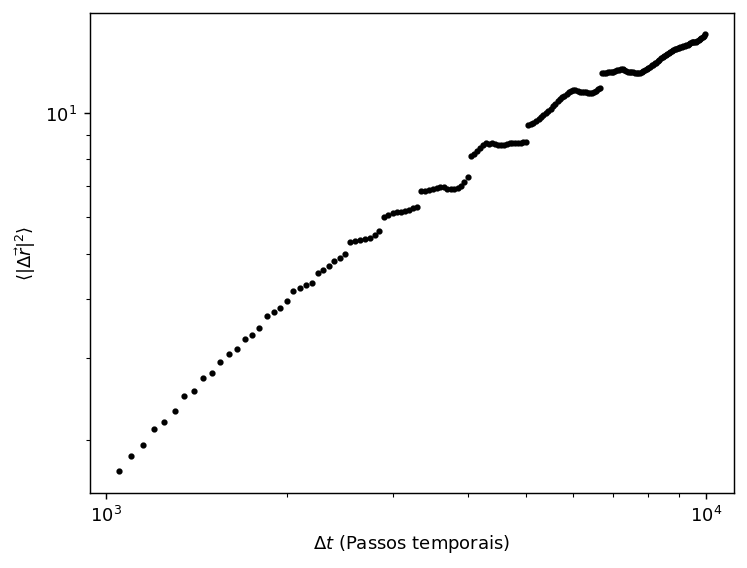

In [57]:
plt.figure(dpi=130)

mask = x_time > 1e3

plt.xlabel("$\Delta t$ (Passos temporais)")
plt.ylabel("$\\langle |\\Delta \\vec r|^2 \\rangle$")
plt.yscale("log")
plt.xscale("log")
plt.scatter(x_time[mask], sq_mean[mask], label="Dados", c="black", s=6)

# plt.savefig("data/images/high_rot_zoom.png")